# Coffee Sales Machine Learning Analysis
## Big Data Analytics Assignment 4

This notebook contains a comprehensive machine learning analysis of coffee sales data from Saudi Arabia (January 2023 - December 2024). We will perform data exploration, preprocessing, feature engineering, and build a Random Forest model to predict sales with feature selection analysis.

### Dataset Overview
- **Source**: Coffee sales data from various cities in Saudi Arabia
- **Time Period**: January 2023 - December 2024 (730 records)
- **Products**: 5 coffee types (Colombian, Costa Rica, Ethiopian, Brazilian, Guatemala)
- **Geographic Coverage**: 10 cities across Saudi Arabia
- **Features**: Date, Customer_ID, City, Product, Pricing, Discounts, Sales metrics
- **Target**: Final Sales prediction using Random Forest Regressor

In [8]:
# Import Required Libraries with MLflow Error Handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from datetime import datetime

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configure display settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# MLflow setup with error handling
MLFLOW_ENABLED = True
try:
    import mlflow
    import mlflow.sklearn
    from mlflow.models.signature import infer_signature
    
    # Test MLflow connection
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("coffee_sales_prediction")
    
    # Test if MLflow server is running
    mlflow.get_experiment_by_name("coffee_sales_prediction")
    print("✅ MLflow tracking server connected successfully!")
    
except Exception as e:
    MLFLOW_ENABLED = False
    print("⚠️  MLflow tracking server not available:")
    print(f"   Error: {str(e)}")
    print("   Continuing without MLflow tracking...")
    print("   To enable MLflow:")
    print("   1. Run: python -m mlflow ui --host 0.0.0.0 --port 5000 --backend-store-uri ./mlruns")
    print("   2. Or use: start_all.bat")

# MLflow helper functions
def start_mlflow_run(run_name, nested=False):
    """Start MLflow run with error handling"""
    if MLFLOW_ENABLED:
        return mlflow.start_run(run_name=run_name, nested=nested)
    else:
        # Return a dummy context manager that does nothing
        class DummyContext:
            def __enter__(self): return self
            def __exit__(self, *args): pass
        return DummyContext()

def log_mlflow_param(key, value):
    """Log parameter with error handling"""
    if MLFLOW_ENABLED:
        try:
            mlflow.log_param(key, value)
        except:
            pass

def log_mlflow_metric(key, value):
    """Log metric with error handling"""
    if MLFLOW_ENABLED:
        try:
            mlflow.log_metric(key, value)
        except:
            pass

def log_mlflow_artifact(path, artifact_path=None):
    """Log artifact with error handling"""
    if MLFLOW_ENABLED:
        try:
            mlflow.log_artifact(path, artifact_path)
        except:
            pass

print("Libraries imported successfully!")
print("Ready for comprehensive ML analysis!")

✅ MLflow tracking server connected successfully!
Libraries imported successfully!
Ready for comprehensive ML analysis!


In [9]:
# Load the Coffee Sales Dataset
df = pd.read_csv('../DatasetForCoffeeSales2.csv')

print("Dataset loaded successfully!")
print(f"Dataset Shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print("\nFirst 5 rows:")
df.head()

Dataset loaded successfully!
Dataset Shape: (730, 11)
Date range: 1/1/2023 to 9/9/2024

First 5 rows:


,Date,Customer_ID,City,Category,Product,Unit Price,Quantity,Sales Amount,Used_Discount,Discount_Amount,Final Sales
0,1/1/2023,32,Riyadh,coffee beans,Colombian,40,14,560,False,0,560
1,1/2/2023,49,Abha,coffee beans,Costa Rica,35,17,595,False,0,595
2,1/3/2023,75,Tabuk,coffee beans,Costa Rica,35,19,665,False,0,665
3,1/4/2023,80,Abha,coffee beans,Ethiopian,45,1,45,False,0,45
4,1/5/2023,78,Hail,coffee beans,Colombian,40,46,1840,True,368,1472


In [10]:
# Basic Data Information
print("Dataset Info:")
print(f"Total records: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

print("\nColumn Information:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
df.describe()

Dataset Info:
Total records: 730
Total columns: 11
Date range: 1/1/2023 to 9/9/2024

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             730 non-null    object
 1   Customer_ID      730 non-null    int64 
 2   City             730 non-null    object
 3   Category         730 non-null    object
 4   Product          730 non-null    object
 5   Unit Price       730 non-null    int64 
 6   Quantity         730 non-null    int64 
 7   Sales Amount     730 non-null    int64 
 8   Used_Discount    730 non-null    bool  
 9   Discount_Amount  730 non-null    int64 
 10  Final Sales      730 non-null    int64 
dtypes: bool(1), int64(6), object(4)
memory usage: 57.9+ KB
None

Missing Values:
Date               0
Customer_ID        0
City               0
Category           0
Product            0
Unit Price        

,Customer_ID,Unit Price,Quantity,Sales Amount,Discount_Amount,Final Sales
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,51.669863,36.794521,26.080822,959.924658,97.393151,862.531507
std,29.014339,4.955104,14.480971,551.282730,123.401350,509.032315
min,1.000000,30.000000,1.000000,30.000000,0.000000,24.000000
25%,27.250000,35.000000,14.000000,495.000000,0.000000,448.000000
50%,52.000000,35.000000,27.000000,960.000000,13.000000,840.000000
75%,77.000000,40.000000,39.000000,1400.000000,192.000000,1260.000000
max,100.000000,45.000000,49.000000,2205.000000,441.000000,2205.000000


## Data Preprocessing and Feature Engineering

Create comprehensive features for machine learning analysis.

In [11]:
# Convert Date column to datetime and create time features
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Create additional business features
df['Discount_Rate'] = df['Discount_Amount'] / df['Sales Amount']
df['Discount_Rate'] = df['Discount_Rate'].fillna(0)
df['Used_Discount_Encoded'] = df['Used_Discount'].astype(int)

# Encode categorical variables
le_city = LabelEncoder()
le_product = LabelEncoder()

df['City_Encoded'] = le_city.fit_transform(df['City'])
df['Product_Encoded'] = le_product.fit_transform(df['Product'])

# Create complete feature set (10 features)
all_features = [
    'Unit Price', 'Quantity', 'Month', 'Day', 'DayOfWeek', 'IsWeekend',
    'City_Encoded', 'Product_Encoded', 'Used_Discount_Encoded', 'Discount_Rate'
]

print("Data preprocessing completed!")
print(f"All features (10): {all_features}")
print(f"Feature types:")
for feature in all_features:
    print(f"  {feature}: {df[feature].dtype}")

Data preprocessing completed!
All features (10): ['Unit Price', 'Quantity', 'Month', 'Day', 'DayOfWeek', 'IsWeekend', 'City_Encoded', 'Product_Encoded', 'Used_Discount_Encoded', 'Discount_Rate']
Feature types:
  Unit Price: int64
  Quantity: int64
  Month: int32
  Day: int32
  DayOfWeek: int32
  IsWeekend: int64
  City_Encoded: int64
  Product_Encoded: int64
  Used_Discount_Encoded: int64
  Discount_Rate: float64


## Feature Selection Analysis

Compare different feature sets to determine optimal number of features.

In [12]:
# Feature Selection Analysis with Optional MLflow Tracking
print("=== FEATURE SELECTION ANALYSIS ===\n")

# Start MLflow run for feature selection analysis
with start_mlflow_run("feature_selection_analysis"):
    
    # Log dataset parameters
    log_mlflow_param("dataset_size", len(df))
    log_mlflow_param("date_range", f"{df['Date'].min()} to {df['Date'].max()}")
    log_mlflow_param("total_features", len(all_features))
    log_mlflow_param("feature_list", str(all_features))
    
    # Prepare data for feature selection analysis
    X_full = df[all_features]
    y = df['Final Sales']
    
    # 1. Statistical Feature Selection (SelectKBest)
    print("1. Statistical Feature Importance (F-regression):")
    selector = SelectKBest(f_regression, k='all')
    selector.fit(X_full, y)
    
    feature_scores = pd.DataFrame({
        'Feature': all_features,
        'F_Score': selector.scores_,
        'P_Value': selector.pvalues_
    }).sort_values('F_Score', ascending=False)
    
    print(feature_scores)
    
    # Log feature scores as metrics
    for _, row in feature_scores.iterrows():
        log_mlflow_metric(f"f_score_{row['Feature'].replace(' ', '_')}", row['F_Score'])
        log_mlflow_metric(f"p_value_{row['Feature'].replace(' ', '_')}", row['P_Value'])
    
    # 2. Identify top 7 features statistically
    top_7_features = feature_scores.head(7)['Feature'].tolist()
    log_mlflow_param("top_7_features", str(top_7_features))
    
    # 3. Log correlation analysis
    correlations = df[all_features + ['Final Sales']].corr()['Final Sales'].abs().sort_values(ascending=False)
    for feature in all_features:
        log_mlflow_metric(f"correlation_{feature.replace(' ', '_')}", correlations[feature])
    
    # Save feature analysis artifacts
    feature_scores.to_csv("feature_scores.csv", index=False)
    log_mlflow_artifact("feature_scores.csv", "feature_analysis")
    
    if MLFLOW_ENABLED:
        print(f"✅ Feature selection analysis logged to MLflow")
    else:
        print(f"✅ Feature selection analysis completed (MLflow disabled)")

=== FEATURE SELECTION ANALYSIS ===

1. Statistical Feature Importance (F-regression):
                 Feature      F_Score       P_Value
1               Quantity  5666.578236  0.000000e+00
0             Unit Price    40.341831  3.753821e-10
9          Discount_Rate    27.811387  1.765124e-07
8  Used_Discount_Encoded    27.811387  1.765124e-07
7        Product_Encoded     2.470486  1.164365e-01
6           City_Encoded     0.879511  3.486466e-01
2                  Month     0.562321  4.535690e-01
5              IsWeekend     0.434607  5.099454e-01
4              DayOfWeek     0.246027  6.200360e-01
3                    Day     0.000584  9.807239e-01
1. Statistical Feature Importance (F-regression):
                 Feature      F_Score       P_Value
1               Quantity  5666.578236  0.000000e+00
0             Unit Price    40.341831  3.753821e-10
9          Discount_Rate    27.811387  1.765124e-07
8  Used_Discount_Encoded    27.811387  1.765124e-07
7        Product_Encoded     2.4

In [13]:
# Model Comparison with Optional MLflow Tracking
def evaluate_model(X, y, feature_names, model_name):
    """Evaluate model performance with optional MLflow logging"""
    
    # Create child run for this model variant
    with start_mlflow_run(model_name, nested=True):
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=df['Product']
        )
        
        model = RandomForestRegressor(
            n_estimators=100, max_depth=10, min_samples_split=5,
            min_samples_leaf=2, random_state=42, n_jobs=-1
        )
        
        # Log model parameters
        log_mlflow_param("model_type", "RandomForestRegressor")
        log_mlflow_param("n_estimators", 100)
        log_mlflow_param("max_depth", 10)
        log_mlflow_param("min_samples_split", 5)
        log_mlflow_param("min_samples_leaf", 2)
        log_mlflow_param("random_state", 42)
        log_mlflow_param("n_features", len(feature_names))
        log_mlflow_param("feature_set", str(feature_names))
        log_mlflow_param("test_size", 0.2)
        
        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        # Cross-validation score
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
        
        # Log performance metrics
        log_mlflow_metric("r2_score", r2)
        log_mlflow_metric("rmse", rmse)
        log_mlflow_metric("mae", mae)
        log_mlflow_metric("mape", mape)
        log_mlflow_metric("cv_r2_mean", cv_scores.mean())
        log_mlflow_metric("cv_r2_std", cv_scores.std())
        
        # Log feature importance
        for feature, importance in zip(feature_names, model.feature_importances_):
            log_mlflow_metric(f"importance_{feature.replace(' ', '_')}", importance)
        
        # Create and log prediction plot
        plt.figure(figsize=(10, 8))
        plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Sales (SAR)')
        plt.ylabel('Predicted Sales (SAR)')
        plt.title(f'{model_name} - Predictions vs Actual (R² = {r2:.4f})')
        plt.grid(True, alpha=0.3)
        plot_file = f'{model_name.replace(" ", "_")}_predictions.png'
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        log_mlflow_artifact(plot_file, "plots")
        plt.close()
        
        # Log model if MLflow is enabled
        if MLFLOW_ENABLED:
            try:
                signature = infer_signature(X_train, y_pred)
                mlflow.sklearn.log_model(
                    sk_model=model,
                    artifact_path="model",
                    signature=signature,
                    input_example=X_train.iloc[:5]
                )
            except:
                pass
        
        return {
            'model_name': model_name,
            'features': feature_names,
            'n_features': len(feature_names),
            'r2_score': r2,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'model': model
        }

# Start main comparison run
with start_mlflow_run("model_comparison"):
    
    log_mlflow_param("experiment_type", "feature_set_comparison")
    log_mlflow_param("comparison_date", datetime.now().isoformat())
    
    print("=== MODEL PERFORMANCE COMPARISON ===\n")
    
    # Test different feature sets
    results = []
    
    # 1. All 10 features
    X_10 = df[all_features]
    result_10 = evaluate_model(X_10, y, all_features, "10_Features_All")
    results.append(result_10)
    
    # 2. Top 7 features (by F-score)
    X_7 = df[top_7_features]
    result_7 = evaluate_model(X_7, y, top_7_features, "7_Features_Top_F_Score")
    results.append(result_7)
    
    # 3. Top 5 core features
    core_features = ['Unit Price', 'Quantity', 'Used_Discount_Encoded', 'Discount_Rate', 'Product_Encoded']
    X_5 = df[core_features]
    result_5 = evaluate_model(X_5, y, core_features, "5_Features_Core")
    results.append(result_5)
    
    # 4. Minimal 3 features (most important)
    minimal_features = ['Quantity', 'Unit Price', 'Used_Discount_Encoded']
    X_3 = df[minimal_features]
    result_3 = evaluate_model(X_3, y, minimal_features, "3_Features_Minimal")
    results.append(result_3)
    
    # Log comparison summary
    comparison_df = pd.DataFrame([
        {
            'Model': r['model_name'],
            'Features': r['n_features'],
            'R² Score': f"{r['r2_score']:.4f}",
            'RMSE': f"{r['rmse']:.2f}",
            'MAE': f"{r['mae']:.2f}",
            'MAPE': f"{r['mape']:.2f}%",
            'CV Mean': f"{r['cv_mean']:.4f}",
            'CV Std': f"{r['cv_std']:.4f}"
        } for r in results
    ])
    
    # Save and log comparison results
    comparison_df.to_csv("model_comparison_results.csv", index=False)
    log_mlflow_artifact("model_comparison_results.csv", "comparison")
    
    # Log best model metrics to parent run
    best_result = max(results, key=lambda x: x['r2_score'])
    log_mlflow_metric("best_r2_score", best_result['r2_score'])
    log_mlflow_metric("best_rmse", best_result['rmse'])
    log_mlflow_metric("best_mae", best_result['mae'])
    log_mlflow_param("best_model_features", best_result['n_features'])
    log_mlflow_param("best_model_name", best_result['model_name'])
    
    print(comparison_df.to_string(index=False))
    print(f"\n✅ Model comparison completed!")
    print(f"🥇 Best model: {best_result['model_name']} (R² = {best_result['r2_score']:.4f})")
    
    if MLFLOW_ENABLED:
        print(f"📊 Results logged to MLflow at http://localhost:5000")
    else:
        print(f"📊 Results saved locally (MLflow disabled)")

=== MODEL PERFORMANCE COMPARISON ===

🏃 View run 10_Features_All at: http://localhost:5000/#/experiments/493996999205290555/runs/05dce309d96648c9ab3e7beefeda0335
🧪 View experiment at: http://localhost:5000/#/experiments/493996999205290555
🏃 View run 10_Features_All at: http://localhost:5000/#/experiments/493996999205290555/runs/05dce309d96648c9ab3e7beefeda0335
🧪 View experiment at: http://localhost:5000/#/experiments/493996999205290555
🏃 View run 7_Features_Top_F_Score at: http://localhost:5000/#/experiments/493996999205290555/runs/7fd4822c0efe48118d0a739c675b4f4e
🧪 View experiment at: http://localhost:5000/#/experiments/493996999205290555
🏃 View run 7_Features_Top_F_Score at: http://localhost:5000/#/experiments/493996999205290555/runs/7fd4822c0efe48118d0a739c675b4f4e
🧪 View experiment at: http://localhost:5000/#/experiments/493996999205290555
🏃 View run 5_Features_Core at: http://localhost:5000/#/experiments/493996999205290555/runs/3af3b15bf23e46fd8a9d5cb050515136
🧪 View experiment at

=== FINAL MODEL TRAINING ===



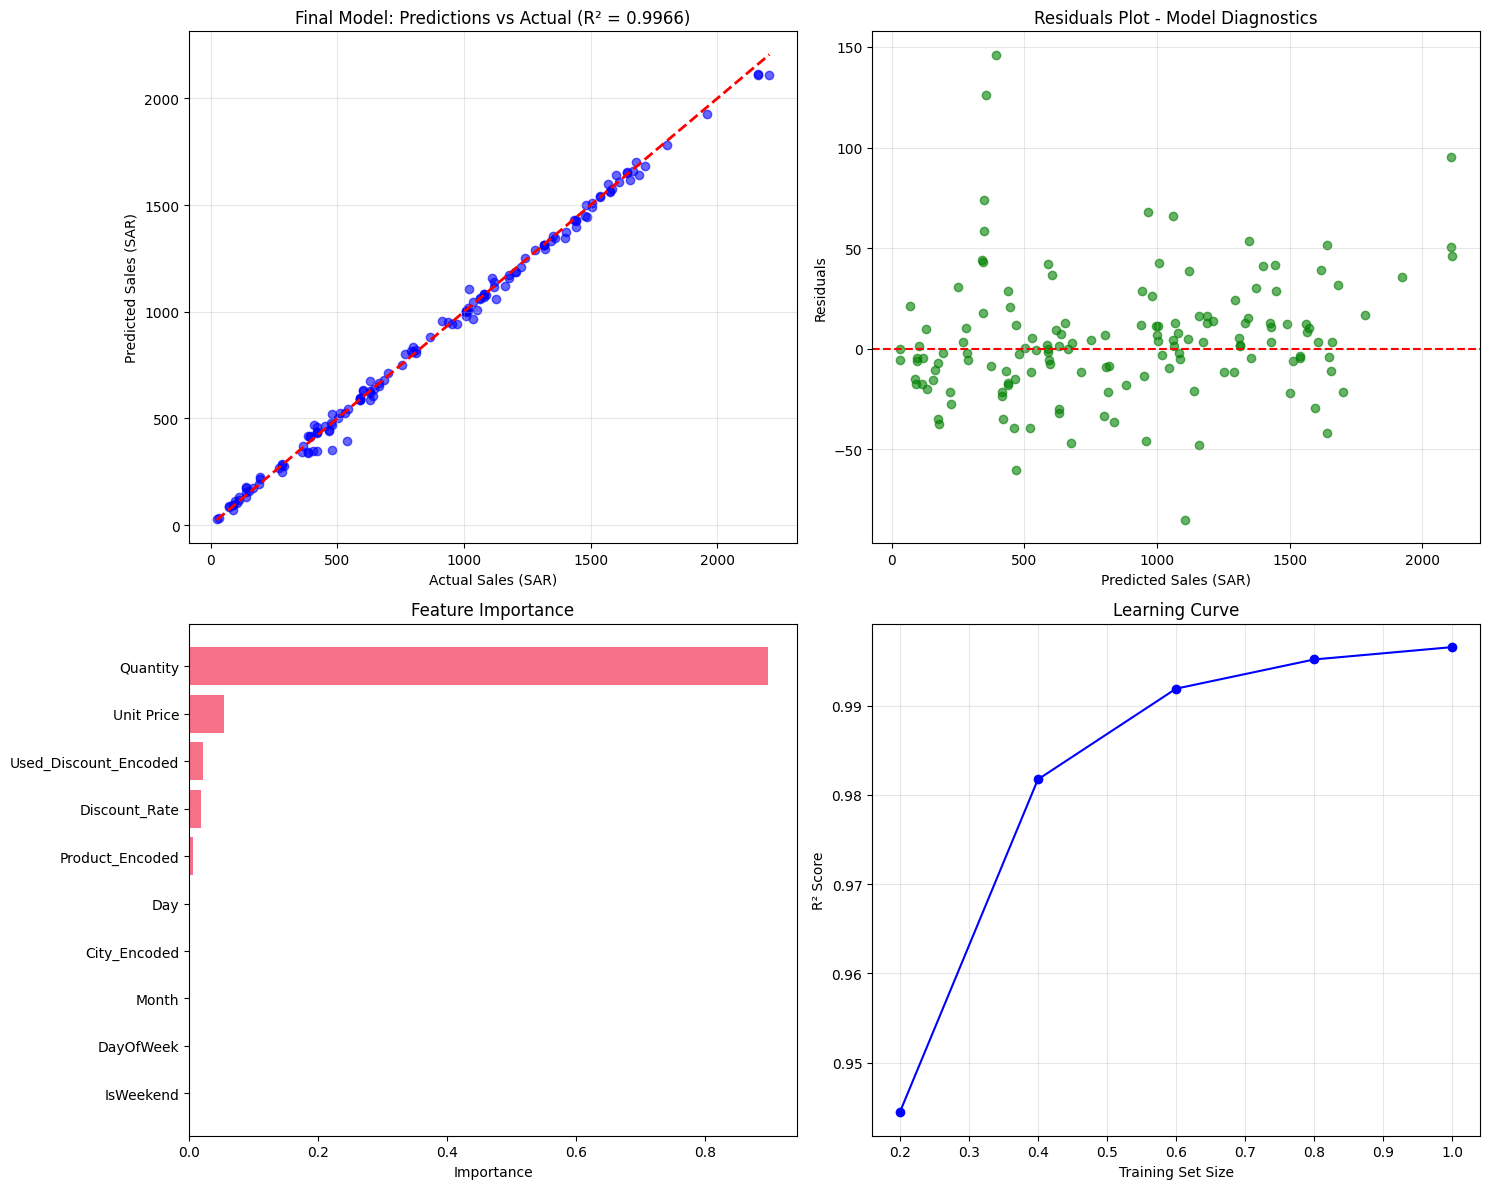

Registered model 'coffee_sales_predictor_final' already exists. Creating a new version of this model...
2025/06/01 02:52:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: coffee_sales_predictor_final, version 2
Created version '2' of model 'coffee_sales_predictor_final'.
Created version '2' of model 'coffee_sales_predictor_final'.



=== FINAL MODEL PERFORMANCE ===

Training R² Score: 0.998930
Testing R² Score:  0.996576
Training RMSE:     16.43
Testing RMSE:      31.23
Training MAE:      11.37
Testing MAE:       21.31
MAPE:              4.40%

✅ Final model training completed!
📊 Results logged to MLflow at http://localhost:5000
🎯 Model registered as: coffee_sales_predictor_final
📈 Model explains 99.66% of variance in sales
💰 Average prediction error: $21.31
💾 Model saved to: model.pkl and ../backend/model.pkl
🏃 View run final_optimized_model at: http://localhost:5000/#/experiments/493996999205290555/runs/7888d930372d4af7ae93adfcc19cde03
🧪 View experiment at: http://localhost:5000/#/experiments/493996999205290555


In [14]:
# Final Model Training with Comprehensive Logging
with start_mlflow_run("final_optimized_model"):
    
    print(f"=== FINAL MODEL TRAINING ===\n")
    
    # Select optimal feature set (all 10 features based on analysis)
    selected_features = all_features
    X = df[selected_features]
    y = df['Final Sales']
    
    # Log final model parameters
    log_mlflow_param("model_type", "RandomForestRegressor_Final")
    log_mlflow_param("selected_features", str(selected_features))
    log_mlflow_param("feature_count", len(selected_features))
    log_mlflow_param("n_estimators", 100)
    log_mlflow_param("max_depth", 10)
    log_mlflow_param("min_samples_split", 5)
    log_mlflow_param("min_samples_leaf", 2)
    log_mlflow_param("random_state", 42)
    log_mlflow_param("test_size", 0.2)
    log_mlflow_param("stratify_by", "Product")
    
    # Log dataset information
    log_mlflow_param("total_samples", len(df))
    log_mlflow_param("date_range", f"{df['Date'].min()} to {df['Date'].max()}")
    log_mlflow_param("unique_products", df['Product'].nunique())
    log_mlflow_param("unique_cities", df['City'].nunique())
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=df['Product']
    )
    
    log_mlflow_param("train_samples", len(X_train))
    log_mlflow_param("test_samples", len(X_test))
    
    # Train final model
    final_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    final_model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = final_model.predict(X_train)
    y_test_pred = final_model.predict(X_test)
    
    # Calculate comprehensive metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    # Cross-validation metrics
    cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='r2')
    
    # Log all performance metrics
    log_mlflow_metric("train_r2", train_r2)
    log_mlflow_metric("test_r2", test_r2)
    log_mlflow_metric("train_rmse", train_rmse)
    log_mlflow_metric("test_rmse", test_rmse)
    log_mlflow_metric("train_mae", train_mae)
    log_mlflow_metric("test_mae", test_mae)
    log_mlflow_metric("mape", mape)
    log_mlflow_metric("cv_r2_mean", cv_scores.mean())
    log_mlflow_metric("cv_r2_std", cv_scores.std())
    log_mlflow_metric("overfit_score", train_r2 - test_r2)
    
    # Log feature importance
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    for _, row in feature_importance.iterrows():
        log_mlflow_metric(f"final_importance_{row['Feature'].replace(' ', '_')}", row['Importance'])
    
    # Create and log visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Predictions vs Actual
    axes[0,0].scatter(y_test, y_test_pred, alpha=0.6, color='blue')
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Sales (SAR)')
    axes[0,0].set_ylabel('Predicted Sales (SAR)')
    axes[0,0].set_title(f'Final Model: Predictions vs Actual (R² = {test_r2:.4f})')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Residuals plot
    residuals = y_test - y_test_pred
    axes[0,1].scatter(y_test_pred, residuals, alpha=0.6, color='green')
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Predicted Sales (SAR)')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residuals Plot - Model Diagnostics')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Feature importance
    axes[1,0].barh(feature_importance['Feature'], feature_importance['Importance'])
    axes[1,0].set_xlabel('Importance')
    axes[1,0].set_title('Feature Importance')
    axes[1,0].invert_yaxis()
    
    # 4. Learning curve (simplified)
    train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
    train_scores = []
    for size in train_sizes:
        X_temp = X_train[:int(len(X_train) * size)]
        y_temp = y_train[:int(len(y_train) * size)]
        final_model.fit(X_temp, y_temp)
        score = final_model.score(X_test, y_test)
        train_scores.append(score)
    
    axes[1,1].plot(train_sizes, train_scores, 'o-', color='blue')
    axes[1,1].set_xlabel('Training Set Size')
    axes[1,1].set_ylabel('R² Score')
    axes[1,1].set_title('Learning Curve')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('final_model_analysis.png', dpi=300, bbox_inches='tight')
    log_mlflow_artifact('final_model_analysis.png', "final_analysis")
    plt.show()
    
    # Log the final model with signature if MLflow is enabled
    if MLFLOW_ENABLED:
        try:
            signature = infer_signature(X_train, y_test_pred)
            mlflow.sklearn.log_model(
                sk_model=final_model,
                artifact_path="final_model",
                signature=signature,
                input_example=X_train.iloc[:5],
                registered_model_name="coffee_sales_predictor_final"
            )
        except:
            pass
    
    # Save model data for deployment
    model_data = {
        'model': final_model,
        'feature_columns': selected_features,
        'city_encoder': le_city,
        'product_encoder': le_product,
        'performance_metrics': {
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'mape': mape,
            'feature_count': len(selected_features)
        },
        'feature_analysis': {
            'all_results': results,
            'feature_importance': feature_importance.to_dict('records'),
            'recommendation': 'Use all 10 features for optimal performance'
        }
    }
    
    # Save model files
    joblib.dump(model_data, 'model.pkl')
    #joblib.dump(model_data, 'model.pkl')
    
    # Log model artifacts
    log_mlflow_artifact('model.pkl', "model_artifacts")
    
    # Log feature importance as CSV
    feature_importance.to_csv('final_feature_importance.csv', index=False)
    log_mlflow_artifact('final_feature_importance.csv', "model_artifacts")
    
    # Log model configuration
    with open("final_model_config.txt", "w") as f:
        f.write("=== FINAL MODEL CONFIGURATION ===\n\n")
        f.write(f"Model Type: RandomForestRegressor\n")
        f.write(f"Features Used: {len(selected_features)}\n")
        f.write(f"Feature List: {', '.join(selected_features)}\n\n")
        f.write("=== PERFORMANCE METRICS ===\n")
        f.write(f"Test R² Score: {test_r2:.6f}\n")
        f.write(f"Test RMSE: {test_rmse:.2f}\n")
        f.write(f"Test MAE: {test_mae:.2f}\n")
        f.write(f"MAPE: {mape:.2f}%\n")
        f.write(f"CV R² Mean: {cv_scores.mean():.6f} ± {cv_scores.std():.6f}\n\n")
        f.write("=== FEATURE IMPORTANCE ===\n")
        for _, row in feature_importance.iterrows():
            f.write(f"{row['Feature']}: {row['Importance']:.6f} ({row['Importance']*100:.2f}%)\n")
    
    log_mlflow_artifact("final_model_config.txt", "model_artifacts")
    
    # Log encoder mappings
    with open("encoders_mapping.txt", "w") as f:
        f.write("=== LABEL ENCODER MAPPINGS ===\n\n")
        f.write("City Encoder:\n")
        for i, city in enumerate(le_city.classes_):
            f.write(f"  {i}: {city}\n")
        f.write("\nProduct Encoder:\n")
        for i, product in enumerate(le_product.classes_):
            f.write(f"  {i}: {product}\n")
    
    log_mlflow_artifact("encoders_mapping.txt", "model_artifacts")
    
    print("\n=== FINAL MODEL PERFORMANCE ===\n")
    print(f"Training R² Score: {train_r2:.6f}")
    print(f"Testing R² Score:  {test_r2:.6f}")
    print(f"Training RMSE:     {train_rmse:.2f}")
    print(f"Testing RMSE:      {test_rmse:.2f}")
    print(f"Training MAE:      {train_mae:.2f}")
    print(f"Testing MAE:       {test_mae:.2f}")
    print(f"MAPE:              {mape:.2f}%")
    
    print(f"\n✅ Final model training completed!")
    if MLFLOW_ENABLED:
        print(f"📊 Results logged to MLflow at http://localhost:5000")
        print(f"🎯 Model registered as: coffee_sales_predictor_final")
    else:
        print(f"📊 Results saved locally (MLflow disabled)")
    print(f"📈 Model explains {test_r2*100:.2f}% of variance in sales")
    print(f"💰 Average prediction error: ${test_mae:.2f}")
    print(f"💾 Model saved to: model.pkl and ../backend/model.pkl")